In [1]:
import pprint

# Data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifiers 
import xgboost

# Analysis libs
from sklearn.model_selection import cross_val_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

In [2]:
malware_data_filepath = '../datasets/Obfuscated/Obfuscated-MalMem2022_edited.csv'
malware_data = pd.read_csv(malware_data_filepath)

In [3]:
X_drop_columns = ['Class', 
                'Category', 
                'svcscan.interactive_process_services', 
                'handles.nport', 
                'modules.nmodules',
                'pslist.nprocs64bit', 
                'callbacks.ngeneric']
X = malware_data.drop(columns=X_drop_columns)

y_column = malware_data.Class
class_le = LabelEncoder()
y = class_le.fit_transform(y_column)

In [4]:
X.shape

(58596, 50)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=0, stratify=y)

In [6]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (41017, 50)
y_train shape: (41017,)
X_test shape: (17579, 50)
y_test shape: (17579,)


In [7]:
xgb = xgboost.XGBClassifier(n_estimators=X.shape[1], learning_rate=1.0, device='cuda')
clf = xgb.fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))

Training accuracy: 1.0
Test accuracy: 0.9998862278855453


In [8]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cm

array([[8789,    1],
       [   1, 8788]])

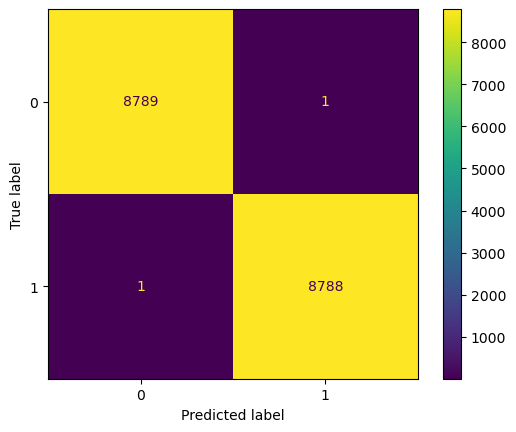

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       1.00      1.00      1.00      8789

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



In [11]:
scores = cross_val_score(clf, X, y, cv=10)

In [12]:
print(f"Scores from CV: {scores}")
print(f"Mean of CV scores: {scores.mean()}")
print(f"Standard Deviation of CV scores: {scores.std()}")

Scores from CV: [0.9996587  1.         0.99982935 1.         0.98976109 1.
 0.99795187 0.99982932 1.         1.        ]
Mean of CV scores: 0.9987030338087258
Standard Deviation of CV scores: 0.0030394670124549218


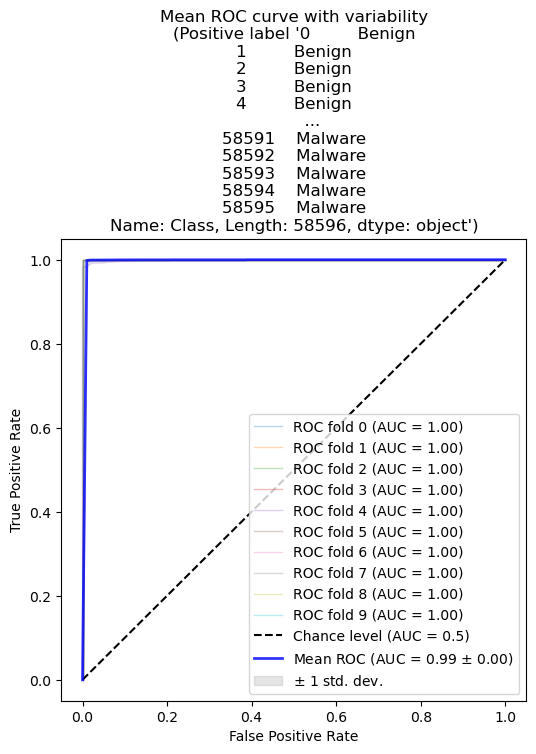

In [13]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
        xgb.fit(X.iloc[train], y[train])
        viz = RocCurveDisplay.from_estimator(
                xgb,
                X.iloc[test],
                y[test],
                name=f"ROC fold {fold}",
                alpha=0.3,
                lw=1,
                ax=ax,
                plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
)

ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label '{malware_data.Class}')",
)
ax.legend(loc="lower right")
plt.show()

## Report and results

In using XGBoost in the Binary-Classification task, we can see that the results are extremely (no pun intended) favorable. We can see that in the confusion matrix that the model classified well and only missed two classifications. When we see the classification report all show overwhelmingly that this model performed well in precision, recall and f1. The accuracy with this model is 0.99 but it can be said to be 1.0 according to the classification report. Lastly, we can see that the ROC or AUC is effectively a right angle, thus meriting the conclusion that XGBoost is extremely well in the binary task.